<img src="../img/hu-logo.png" align="right" width="120">

# Hierarchical Clustering

In this notebook we will implement ___Hierarchical Clustering___ with

- Euclidean distances
- single linkage

We compare the results to those obtained by `sklearn` and visualize the clustering logic in a dendrogram plot.

In [1]:
import copy
import celluloid

import numpy as np
import pandas as pd

import sklearn.cluster

import scipy.spatial # distance
import scipy.cluster.hierarchy

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
})

## Background

__Hierarchical clustering__ is a family of clustering algorithms. The idea is to build nested clusters by iteratively (1) merging or (2) splitting clusters.

__Agglomerative Clustering__ object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and then clusters are merged step by step.

We can choose different linkage criteria for the merge strategy:

1. Ward: minimizes the sum of squared differences within all clusters (i.e., it is a variance-minimizing approach).
2. Complete linkage (maximum linkage): minimize the maximum distance between observations of pairs of clusters.
3. Average linkage: minimize the average of the distances between all observations of pairs of clusters.
4. Single linkage: minimize the distance between the closest observations of pairs of clusters.

Note Ward's conceptual similarity to the the k-means objective function.

We have various choices for the distance metric, e.g., 

1. Euclidean distance $\|a-b\|_{2}={\sqrt  {\sum _{i}(a_{i}-b_{i})^{2}}}$
2. Manhattan distance $\|a-b\|_{1}=\sum _{i}|a_{i}-b_{i}|$
3. Maximum distance $\|a-b\|_{\infty }=\max _{i}|a_{i}-b_{i}|$


This hierarchy of clusters can be visualized as a tree (`dendrogram`). The _root_ of the tree is the cluster that contains all samples, the _leaves_ are the clusters containing only one sample each.

In this notebook, we will explore a simple case of agglomerative clustering with single linkage.

## Algorithm

1. Start with most granular partioning, each point is a cluster
2. Compute distance matrix
3. `while` at least one distance smaller than distance threshold:
    1. Merge clusters with smallest distances
    2. Compute/update distances (based on selected linkage method)

## Data

Define samples in a two-dimensional space so we can easily visualize the data and interpret distances.

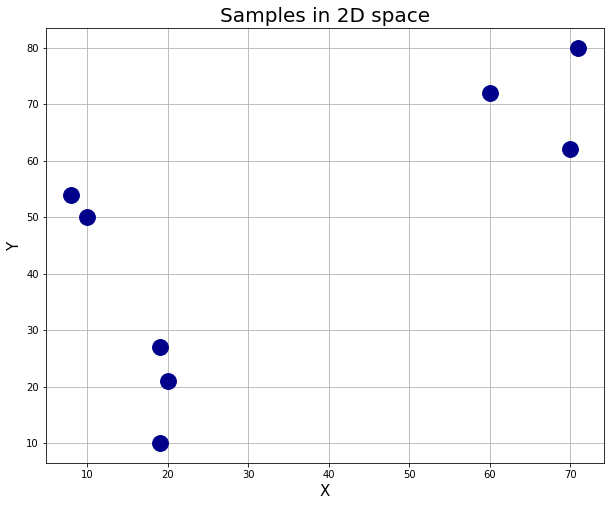

In [2]:
# manually create some data
coordinates = np.array(
    [
        [20,21],
        [10,50],
        [ 8,54],
        [19,27],
        [19,10],
        [71,80],
        [60,72],
        [70,62],
    ]
)

df = pd.DataFrame(
    coordinates,
    columns=["x", "y"]
)

# id for each point, used later in cluster assignments
points = list(range(coordinates.shape[0]))

# plot clustesr
fig, ax = plt.subplots()
ax.scatter(x="x", y="y", data=df, c="darkblue", s=250)
plt.title("Samples in 2D space")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Distance matrix

- quadratic and symmetric matrix
- diagonal is 0 (distance of point to itself!)
- a distance matrix therefore contains $\frac n 2 (n-1)$ values

In [3]:
dist_raw = scipy.spatial.distance.cdist(
    df.values,
    df.values,
    metric="euclidean"
).round(3)

dist_raw

array([[ 0.   , 30.676, 35.114,  6.083, 11.045, 77.987, 64.815, 64.661],
       [30.676,  0.   ,  4.472, 24.698, 41.   , 67.978, 54.626, 61.188],
       [35.114,  4.472,  0.   , 29.155, 45.354, 68.154, 55.027, 62.514],
       [ 6.083, 24.698, 29.155,  0.   , 17.   , 74.25 , 60.877, 61.855],
       [11.045, 41.   , 45.354, 17.   ,  0.   , 87.201, 74.33 , 72.835],
       [77.987, 67.978, 68.154, 74.25 , 87.201,  0.   , 13.601, 18.028],
       [64.815, 54.626, 55.027, 60.877, 74.33 , 13.601,  0.   , 14.142],
       [64.661, 61.188, 62.514, 61.855, 72.835, 18.028, 14.142,  0.   ]])

In [4]:
# turn distance matrix into pandas dataframe ("long" format)
ind = np.tril_indices(dist_raw.shape[0], -1)
df_dist = pd.DataFrame({
    "i": ind[0],
    "j": ind[1],
    "d": dist_raw[ind],
}).sort_values("d")
df_dist.head(10).reset_index(drop=True)

,i,j,d
0,2,1,4.472
1,3,0,6.083
2,4,0,11.045
3,6,5,13.601
4,7,6,14.142
5,4,3,17.000
6,7,5,18.028
7,3,1,24.698
8,3,2,29.155
9,1,0,30.676


<br>
<br>

## Manual implementation

### Initialize

#### Cluster assignments

We model cluster assignments by `dict`s.

#### Cluster &rarr; Point(s)

A cluster must contain one or more points. We model the map as a dict containing lists.

In [5]:
cluster = {
    i: [i]
    for i in points
}
cluster

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7]}

#### Point &rarr; Cluster

A point must belong to exactly one cluster. We model the cluster assignment as a dict containing cluster IDs (int). 

In [6]:
cluster_inv = {}
for k in cluster:
    for i in cluster[k]:
        cluster_inv[i] = k
cluster_inv

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

#### Logging

We log all steps in a dict.

In [7]:
i = -1
cluster_all = {}
cluster_all[i] = copy.deepcopy(cluster)
print(cluster_all)

cluster_new_all = {}

cluster_inv_all = {}
cluster_inv_all[i] = copy.deepcopy(cluster_inv)
print(cluster_inv_all)

{-1: {0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7]}}
{-1: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}}


### Training

Merge clusters for two closest points. If the points are already in the same cluster, skip to next iteration.

In [8]:
while len(cluster)>1:

    i += 1

    print(f"\n\nIteration {i}")

    cluster_new = [
        df_dist.i.iloc[i],
        df_dist.j.iloc[i]
    ]
    cluster_new_all[i] = copy.deepcopy(cluster_new)

    if cluster_inv[cluster_new[0]] == cluster_inv[cluster_new[1]]:
        print("No update")
        updated = False
    else:
        print("merge")
        print(cluster_new)
        cluster[cluster_inv[cluster_new[1]]] += cluster[cluster_inv[cluster_new[0]]]
        del cluster[cluster_inv[cluster_new[0]]]
        updated = True

    cluster_inv = {}
    for k in cluster:
        for x in cluster[k]:
            cluster_inv[x] = k

    cluster_all[i] = copy.deepcopy(cluster)
    cluster_inv_all[i] = copy.deepcopy(cluster_inv)

    if updated:
        print("Cluster -> Point(s)")
        print(cluster)

        print("Point -> Cluster")
        print(cluster_inv)



Iteration 0
merge
[2, 1]
Cluster -> Point(s)
{0: [0], 1: [1, 2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7]}
Point -> Cluster
{0: 0, 1: 1, 2: 1, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


Iteration 1
merge
[3, 0]
Cluster -> Point(s)
{0: [0, 3], 1: [1, 2], 4: [4], 5: [5], 6: [6], 7: [7]}
Point -> Cluster
{0: 0, 3: 0, 1: 1, 2: 1, 4: 4, 5: 5, 6: 6, 7: 7}


Iteration 2
merge
[4, 0]
Cluster -> Point(s)
{0: [0, 3, 4], 1: [1, 2], 5: [5], 6: [6], 7: [7]}
Point -> Cluster
{0: 0, 3: 0, 4: 0, 1: 1, 2: 1, 5: 5, 6: 6, 7: 7}


Iteration 3
merge
[6, 5]
Cluster -> Point(s)
{0: [0, 3, 4], 1: [1, 2], 5: [5, 6], 7: [7]}
Point -> Cluster
{0: 0, 3: 0, 4: 0, 1: 1, 2: 1, 5: 5, 6: 5, 7: 7}


Iteration 4
merge
[7, 6]
Cluster -> Point(s)
{0: [0, 3, 4], 1: [1, 2], 5: [5, 6, 7]}
Point -> Cluster
{0: 0, 3: 0, 4: 0, 1: 1, 2: 1, 5: 5, 6: 5, 7: 5}


Iteration 5
No update


Iteration 6
No update


Iteration 7
merge
[3, 1]
Cluster -> Point(s)
{1: [1, 2, 0, 3, 4], 5: [5, 6, 7]}
Point -> Cluster
{1: 1, 2: 1, 0: 1, 3: 1, 4: 1, 5: 5, 6

## Updating the distance matrix

In [9]:
dist_raw.round(2)

array([[ 0.  , 30.68, 35.11,  6.08, 11.04, 77.99, 64.82, 64.66],
       [30.68,  0.  ,  4.47, 24.7 , 41.  , 67.98, 54.63, 61.19],
       [35.11,  4.47,  0.  , 29.16, 45.35, 68.15, 55.03, 62.51],
       [ 6.08, 24.7 , 29.16,  0.  , 17.  , 74.25, 60.88, 61.86],
       [11.04, 41.  , 45.35, 17.  ,  0.  , 87.2 , 74.33, 72.83],
       [77.99, 67.98, 68.15, 74.25, 87.2 ,  0.  , 13.6 , 18.03],
       [64.82, 54.63, 55.03, 60.88, 74.33, 13.6 ,  0.  , 14.14],
       [64.66, 61.19, 62.51, 61.86, 72.83, 18.03, 14.14,  0.  ]])

In [10]:
dist_reduced_0 = dist_raw[
    np.ix_(
        np.delete(points, cluster_new_all[0][0]),
        np.delete(points, cluster_new_all[0][0])
       )
]
dist_reduced_0.round(2)

array([[ 0.  , 30.68,  6.08, 11.04, 77.99, 64.82, 64.66],
       [30.68,  0.  , 24.7 , 41.  , 67.98, 54.63, 61.19],
       [ 6.08, 24.7 ,  0.  , 17.  , 74.25, 60.88, 61.86],
       [11.04, 41.  , 17.  ,  0.  , 87.2 , 74.33, 72.83],
       [77.99, 67.98, 74.25, 87.2 ,  0.  , 13.6 , 18.03],
       [64.82, 54.63, 60.88, 74.33, 13.6 ,  0.  , 14.14],
       [64.66, 61.19, 61.86, 72.83, 18.03, 14.14,  0.  ]])

In [11]:
dist_reduced_1 = dist_raw[
    np.ix_(
        np.delete(points, cluster_new_all[0][1]),
        np.delete(points, cluster_new_all[0][1])
       )
]
dist_reduced_1.round(2)

array([[ 0.  , 35.11,  6.08, 11.04, 77.99, 64.82, 64.66],
       [35.11,  0.  , 29.16, 45.35, 68.15, 55.03, 62.51],
       [ 6.08, 29.16,  0.  , 17.  , 74.25, 60.88, 61.86],
       [11.04, 45.35, 17.  ,  0.  , 87.2 , 74.33, 72.83],
       [77.99, 68.15, 74.25, 87.2 ,  0.  , 13.6 , 18.03],
       [64.82, 55.03, 60.88, 74.33, 13.6 ,  0.  , 14.14],
       [64.66, 62.51, 61.86, 72.83, 18.03, 14.14,  0.  ]])

In [12]:
np.minimum(dist_reduced_0, dist_reduced_1).round(2)

array([[ 0.  , 30.68,  6.08, 11.04, 77.99, 64.82, 64.66],
       [30.68,  0.  , 24.7 , 41.  , 67.98, 54.63, 61.19],
       [ 6.08, 24.7 ,  0.  , 17.  , 74.25, 60.88, 61.86],
       [11.04, 41.  , 17.  ,  0.  , 87.2 , 74.33, 72.83],
       [77.99, 67.98, 74.25, 87.2 ,  0.  , 13.6 , 18.03],
       [64.82, 54.63, 60.88, 74.33, 13.6 ,  0.  , 14.14],
       [64.66, 61.19, 61.86, 72.83, 18.03, 14.14,  0.  ]])

### Plot

In [13]:
cluster_inv_all.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [14]:
fig, ax = plt.subplots(figsize=(12,10))
plt.grid()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Animation of linkage and cluster membership")

camera = celluloid.Camera(fig)
for i in cluster_inv_all.keys():
    for key in cluster_all[i]:
        points_subcluster = cluster_all[i][key]
        for ix in points_subcluster:
            for jx in points_subcluster:
                if ix < jx:
                    ax.plot(
                        [coordinates[ix][0], coordinates[jx][0]],
                        [coordinates[ix][1], coordinates[jx][1]], 
                        c="darkorange",
                        #linestyle="dashed",
                        linewidth=3,
                        alpha=.5,
                        zorder=1
                    )
    ax.scatter(x="x", y="y", data=df, c='b', s=250, label=str(i), zorder=2)
    ax.legend([f"Epoch: {i}"], loc="upper left")
    camera.snap()

plt.close()

In [15]:
# animate cluster creation (i.e., "links" between points)
clustering = camera.animate()

clustering.save(
    "../img/clustering.gif",
    writer="pillow",
    dpi=100,
    fps=1,
)

<img src="../img/clustering.gif" width=800>

<br>

## Reference solution `sklearn`

### Run agglomerative clustering

In [16]:
config_ac = {
    "affinity": "euclidean",
    "linkage": "single",
    "distance_threshold": 0,
    "n_clusters": None,
}

In [17]:
model = sklearn.cluster.AgglomerativeClustering(
   **config_ac
)
model = model.fit(df.values)

### Plot dendrogram

A dendrogram is a diagram representing a tree, visualizing the arrangement of the clusters produced by the respective clustering method along with the distance threshold that determines cluster fusion.

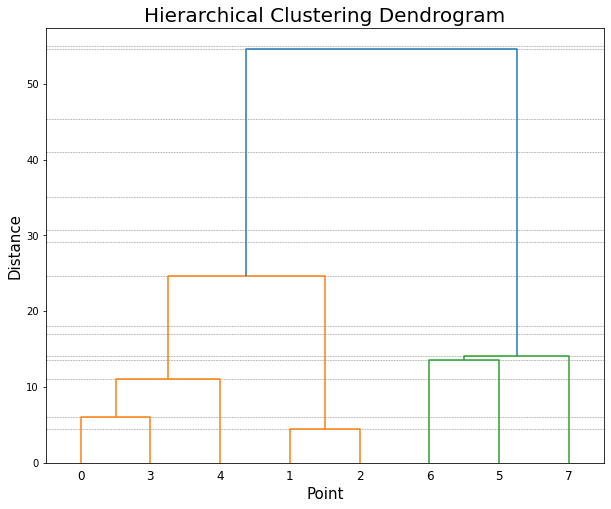

In [18]:
def plot_dendrogram(model, **kwargs):
    """
    Source: See [1]
    """
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    scipy.cluster.hierarchy.dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')

for i in range(15):
    plt.axhline(df_dist.d.iloc[i], linestyle="--", c='grey', zorder=1, linewidth=0.5)
plot_dendrogram(model, truncate_mode=None)
plt.xlabel("Point")
plt.ylabel("Distance")
plt.grid(False)
plt.show()

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 4 <br>
2020 <br>

[1] The function `plot_dendrogram` is borrowed from [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).